## Importing Libraries

In [1]:
# Essentials
import numpy as np
import matplotlib.pyplot as plt

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# Other Requirements
from sklearn.metrics import r2_score
from einops import rearrange
import gc # Garbage collector
import os
from tqdm import tqdm, trange

# My module
from CosmoFuncs import notify

# Setting up the random seeds and CPU threads
# Comment out when different initializations needed
seed = 5675
torch.manual_seed(seed)
np.random.seed(seed)
torch.set_num_threads(20)

# Setting up the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:",device)

Device: cuda


## Data Loading and Visaulization

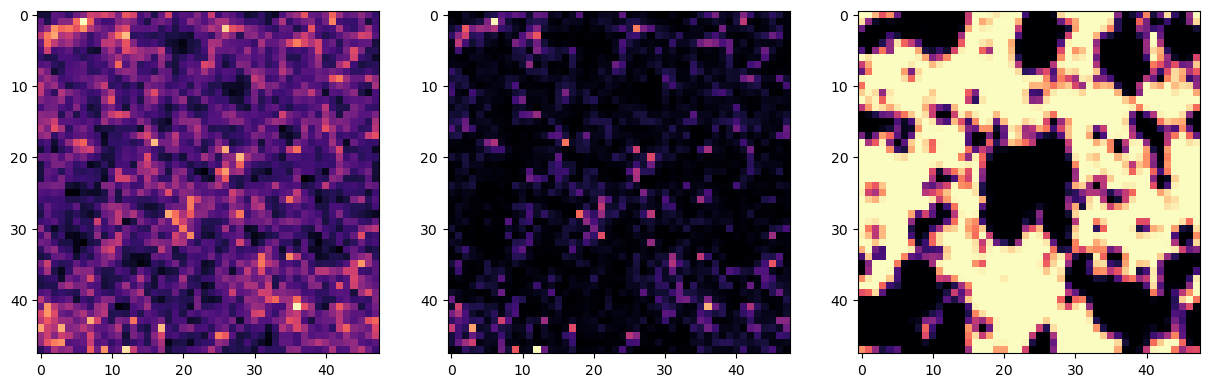

In [5]:
# Data
dm = np.load('/media/disk2/prasad/215Mpc_DM_HM/ReducedDM.npy')
halo = np.load('/media/disk2/prasad/215Mpc_DM_HM/ReducedHalo.npy')
index=736
nff = np.load(f'/media/disk2/prasad/ReducedData48/xHI{index}.npy')

fig, axs = plt.subplots(1,3, figsize=(15, 5))
axs[0].imshow(dm[24], cmap='magma')
axs[1].imshow(halo[24], cmap='magma')
axs[2].imshow(nff[24], cmap='magma')

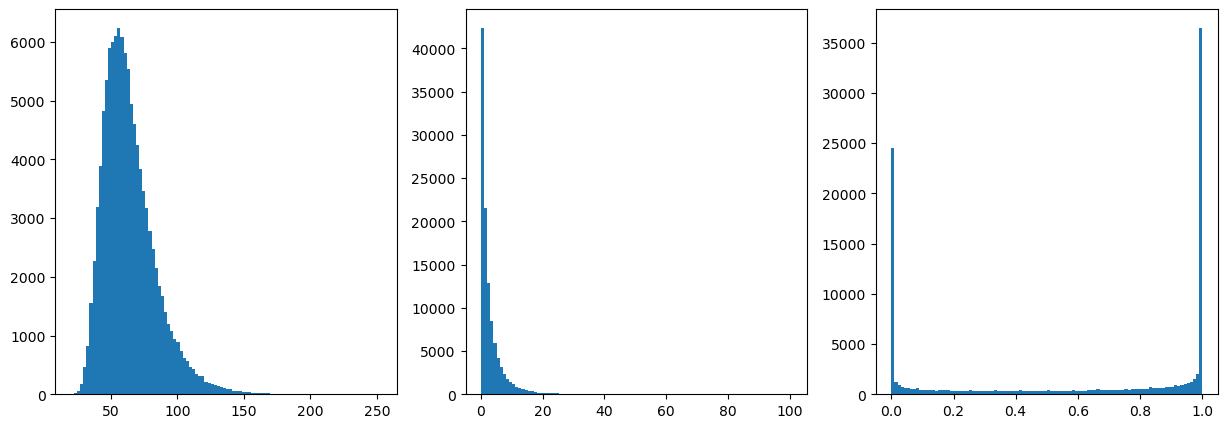

In [20]:
fig, axs = plt.subplots(1,3, figsize=(15, 5))
axs[0].hist(dm.flatten(), bins=100)
axs[1].hist(halo.flatten(), bins=100)
axs[2].hist(nff.flatten(), bins=100);

## Data Preprocessing: Normalizing the input fields

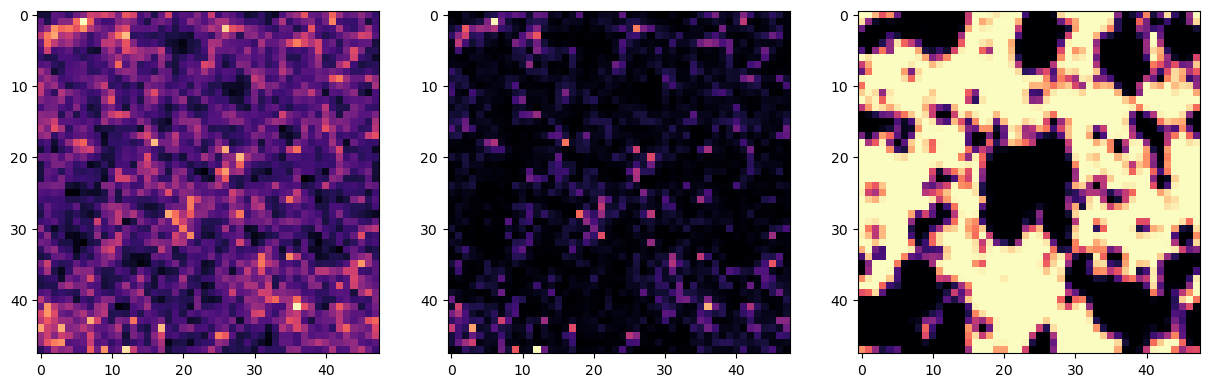

In [21]:
# Noramlized Inputs
norm_dm = (dm - np.mean(dm))/(np.std(dm))
norm_halo = (halo - np.mean(halo))/(np.std(halo))
index=736
nff = np.load(f'/media/disk2/prasad/ReducedData48/xHI{index}.npy')

fig, axs = plt.subplots(1,3, figsize=(15, 5))
axs[0].imshow(norm_dm[24], cmap='magma')
axs[1].imshow(norm_halo[24], cmap='magma')
axs[2].imshow(nff[24], cmap='magma')

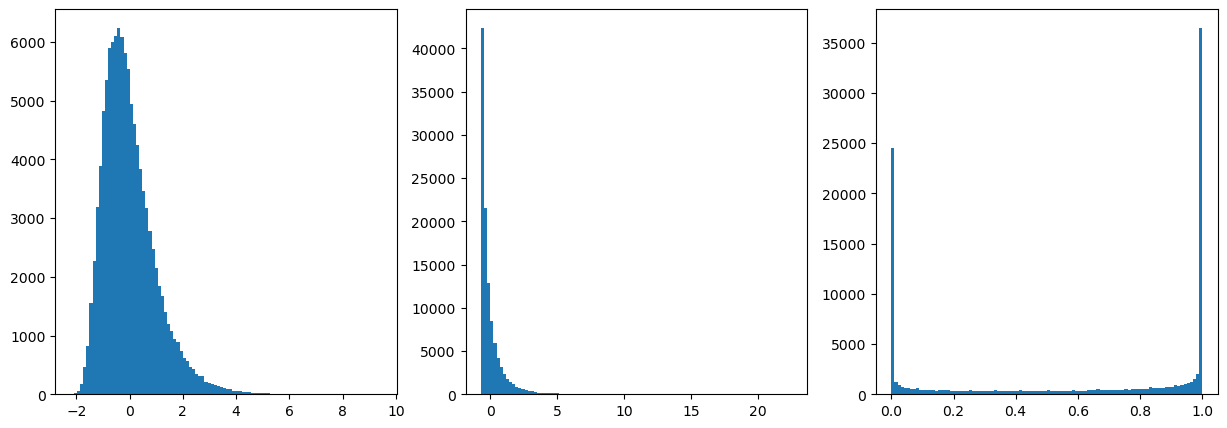

In [22]:
fig, axs = plt.subplots(1,3, figsize=(15, 5))
axs[0].hist(norm_dm.flatten(), bins=100)
axs[1].hist(norm_halo.flatten(), bins=100)
axs[2].hist(nff.flatten(), bins=100);

### Converting the normalized fields to pytorch tensors and expanding dimensions based on the need of architecture

In [23]:
input_dm = torch.tensor(np.expand_dims(norm_dm, axis=[0,1]), dtype=torch.float32)
input_halo = torch.tensor(np.expand_dims(norm_halo, axis=[0,1]), dtype=torch.float32)
print(input_dm.shape, input_halo.shape)

torch.Size([1, 1, 48, 48, 48]) torch.Size([1, 1, 48, 48, 48])


## Model Components

### Patchifying

Q. Wouldn't the spatial information would be lost after breaking the cube into patches?

torch.Size([1, 512, 216])


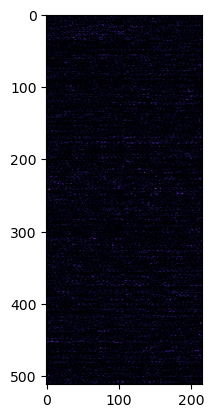

In [24]:
# Breaking down the cube into small subcubes called patches
def Patches3D(data_cube, patch_size):
    return rearrange(data_cube, 'b c (d p1) (h p2) (w p3) -> b (d h w) (p1 p2 p3 c)',  p1=patch_size, p2=patch_size, p3=patch_size)

# Lets break halo cube into patches
halo_patches = Patches3D(input_halo, 6)
print(halo_patches.shape)
plt.imshow(halo_patches[0], cmap='magma')

### Positional Embedding
Q. Why there is a need of positional encoding in transformers?<br>
Q. Why this specific positional encoding is chosen?<br>
Q. Effect on the architecture if you dont use positional encoding?

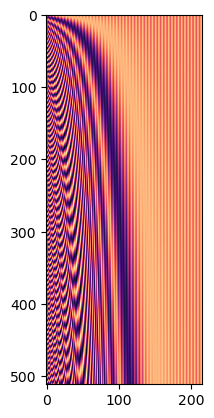

In [25]:
def PositionalEmbedding(num_patches, flattened_dim):
    x = np.arange(0, flattened_dim)
    y = np.arange(0, num_patches)
    X, Y = np.meshgrid(x, y)
    io =  np.where(X%2==0, np.sin(Y / (10000 ** (X / flattened_dim))), np.cos(Y / (10000 ** ((X - 1) / flattened_dim)) ))
    return torch.tensor(io, dtype=torch.float32, requires_grad=False) #requiures grad is set up false since it will be kept constant throughout

pos_embdng = PositionalEmbedding(512, 216)
plt.imshow(pos_embdng, cmap='magma')

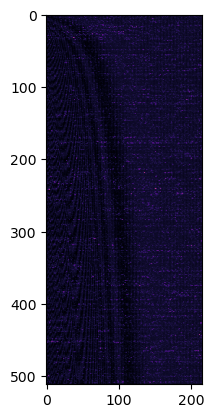

In [26]:
# Adding Positional Embedding to the inputs
patched_halo_w_pos_embdng = halo_patches+pos_embdng
plt.imshow(patched_halo_w_pos_embdng[0], cmap='magma')

torch.Size([1, 1, 48, 48, 48])
tensor(0.)


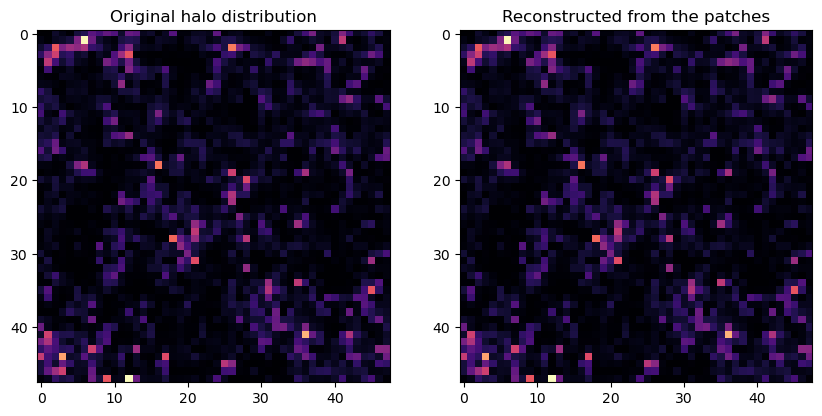

In [27]:
# Reconstructing the halos back
# This step is not needed in the original architecture just used here for demonstration purpose
def Unpatch3D(patches, patch_size, original_shape):
    return rearrange(patches, 'b (d h w) (p1 p2 p3 c) -> b c (d p1) (h p2) (w p3)', p1=patch_size, p2=patch_size, p3=patch_size,
                     d=original_shape[2] // patch_size, 
                     h=original_shape[3] // patch_size, 
                     w=original_shape[4] // patch_size)
    
unpatched_halo = Unpatch3D(halo_patches, 6, (1,1,48,48,48))
print(unpatched_halo.shape)

fig, axs = plt.subplots(1,2, figsize=(10,5))
axs[1].imshow(unpatched_halo[0][0][24], cmap='magma')
axs[1].set_title("Reconstructed from the patches")
axs[0].imshow(input_halo[0][0][24], cmap='magma')
axs[0].set_title("Original halo distribution")
print(torch.sum(unpatched_halo-input_halo)) # Meaning our function is working

tensor(29404.3262)


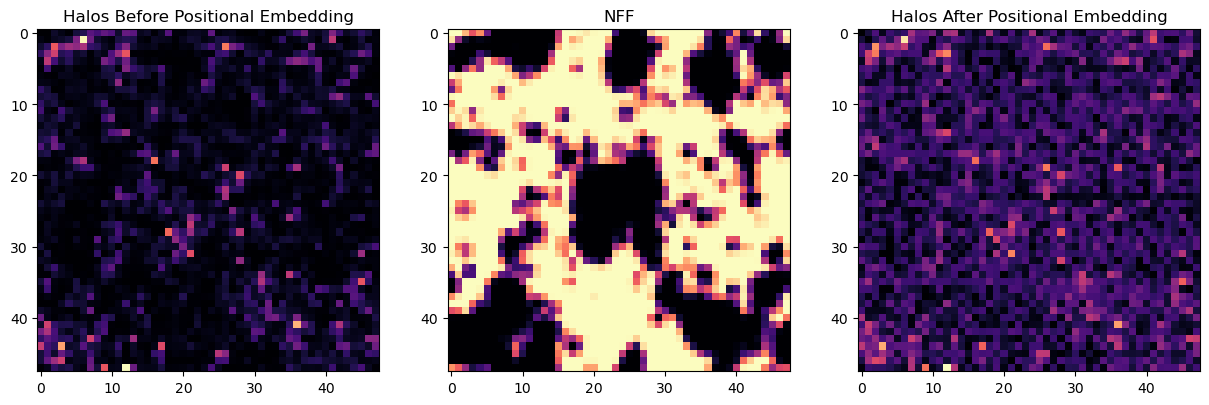

In [28]:
fig, axs = plt.subplots(1,3, figsize=(15,5))
unpatched_halo_w_pos_embdng = Unpatch3D(patched_halo_w_pos_embdng, 6, (1,1,48,48,48))
axs[2].imshow(unpatched_halo_w_pos_embdng[0][0][24], cmap='magma')
axs[2].set_title("Halos After Positional Embedding")
axs[0].imshow(input_halo[0][0][24], cmap='magma')
axs[0].set_title("Halos Before Positional Embedding")
axs[1].imshow(nff[24], cmap='magma')
axs[1].set_title('NFF')
print(torch.sum(unpatched_halo_w_pos_embdng-input_halo))

Q. This features the positional embedding is adding seem unnecessary and possibly making the different inputs to have same impact leading to the same type of realization at the end, hence, vit without positional embedding is a must try

## PatchEncoder
Instead of directly adding the position to the flattened sub-cubes we add it to their linear projection

In [29]:
class PatchEncoder3D(nn.Module):
    def __init__(self, flattened_dim):
        super(PatchEncoder3D, self).__init__()
        self.projection = nn.Linear(flattened_dim, flattened_dim)

    def forward(self, patches, embedding):
        return self.projection(patches) #+ embedding.to(device)

## TransformerBlock
Taken from `An Image Is Worth 16x16 Words`<br><br>
![TransformerBlock](/media/disk1/prasad/codes/ModelArchitectures/PlotsandImages/TransformerBlock.png)

<b> Note: </b> <br>
All the inputs before the transformer block were in the shape `(n, 512, 216)` giving us (batch_size, sequence_length, feature_length) where sequence_length is number of patches/tokens and feature_length is length of each flattened patch or token<br>
However, the transformer takes input as `(512, n, 216)` i.e. (sequence_length, batch_size, feature_length) hence necessary changes should be made before feeding the inputs to transformer block.

In [30]:
class TransformerBlock(nn.Module):
    def __init__(self, flattened_dim, num_heads, ff_dim, dropout_rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = nn.MultiheadAttention(flattened_dim, num_heads)
        self.ffn = nn.Sequential(
            nn.Linear(flattened_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, flattened_dim)
        )
        self.layernorm1 = nn.LayerNorm(flattened_dim)
        self.layernorm2 = nn.LayerNorm(flattened_dim)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.dropout2 = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.layernorm1(x) #Norm
        attn_output, _ = self.att(x, x, x) # MHA
        attn_output = self.dropout1(attn_output) # Dropout to avoid overfitting
        out1 = self.layernorm2(x + attn_output) # Adding to the og then Norm
        ffn_output = self.ffn(out1) # MLP
        ffn_output = self.dropout2(ffn_output) # Dropout to avoid overfitting
        return out1 + ffn_output # Adding to the og

Q. What effect will it have if we increase the number of attention heads, depth of the feed forward networks and repeated the transformer block more number of times?<br>
Q. Why do we need to permute the input before feeding it to it?

# Attention Needed Here:
## Residual Connections
Q. Why do we need them and how do they carry the spatial information?<br>
Q. Why are they defined so and what each part contributes?<br>
Q. How do they help with vanishing gradient problem?<br>
Q. I'm anyway not downsampling it in the second convolution so can i remove it?

In [31]:
class ResidualBlock3D(nn.Module):
    def __init__(self, filters, downsample, kernel_size=3):
        super(ResidualBlock3D, self).__init__()
        self.conv1 = nn.Conv3d(filters, filters, kernel_size, stride=2 if downsample else 1, padding=1)
        self.bn1 = nn.BatchNorm3d(filters)
        self.conv2 = nn.Conv3d(filters, filters, kernel_size, stride=1, padding=1)
        self.bn2 = nn.BatchNorm3d(filters)
        self.downsample = downsample

        if downsample:
            self.downsample_layer = nn.Conv3d(filters, filters, 1, stride=2)

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = F.relu(self.bn1(out))
        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample:
            residual = self.downsample_layer(residual)

        out += residual
        out = F.relu(out)
        return out

# Model Architecture
Q. Modify this architecture based on patch size 6, and no positional embedding

### For deciding the values required in the upsampling process
```python
from Convolver import ConvTranspose3DOutput
input_image = 40
output_image = 48
for filter_size in range(10):
    for stride in range(10):
        for input_padding in range(10):
            for output_padding in range(10):
                if output_padding<stride:
                    outn = ConvTranspose3DOutput(input_image, filter_size, stride, input_padding, output_padding)
                    if outn==output_image:
                        print(filter_size, stride, input_padding, output_padding)
                else:
                    pass
```

In [32]:
class CosmoViT(nn.Module):
    def __init__(self, patch_size, num_patches, flattened_dim, num_heads, ff_dim, param_dim=3):
        super(CosmoViT, self).__init__()
        
        self.patch_size = patch_size
        self.num_patches = num_patches
        self.flattened_dim = flattened_dim
        
        self.encoder1 = PatchEncoder3D(flattened_dim)
        self.encoder2 = PatchEncoder3D(flattened_dim)
        
        self.param_encoder = nn.Linear(param_dim, flattened_dim)
        
        self.transformer_blocks = nn.Sequential(
            TransformerBlock(flattened_dim, num_heads, ff_dim),
            TransformerBlock(flattened_dim, num_heads, ff_dim), # uncomment multiple attention blocks and run
            TransformerBlock(flattened_dim, num_heads, ff_dim),
            TransformerBlock(flattened_dim, num_heads, ff_dim)
        )
        
        self.conv_transpose1 = nn.ConvTranspose3d(432, 256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.bn1 = nn.BatchNorm3d(256)
        self.residual1 = ResidualBlock3D(256, downsample=False)

        self.conv_transpose2 = nn.ConvTranspose3d(256, 128, kernel_size=3, stride=2, padding=5, output_padding=1)
        self.bn2 = nn.BatchNorm3d(128)
        self.residual2 = ResidualBlock3D(128, downsample=False)

        self.conv_transpose3 = nn.ConvTranspose3d(128, 64, kernel_size=3, stride=2, padding=9, output_padding=1) # not good combination
        self.bn3 = nn.BatchNorm3d(64)
        self.residual3 = ResidualBlock3D(64, downsample=False)

        self.conv_transpose4 = nn.ConvTranspose3d(64, 32, kernel_size=9, stride=1, padding=0, output_padding=0) # how large input padding will affect the output?
        self.bn4 = nn.BatchNorm3d(32)
        self.residual4 = ResidualBlock3D(32, downsample=False)
        
        self.conv_transpose5 = nn.ConvTranspose3d(32, 16, kernel_size=9, stride=1, padding=0, output_padding=0) # how large input padding will affect the output?
        self.bn5 = nn.BatchNorm3d(16)
        self.residual5 = ResidualBlock3D(16, downsample=False)

        self.final_conv = nn.Conv3d(16, 1, kernel_size=3, stride=1, padding=1)
        
    def forward(self, x1, x2, params):
        
        x1 = Patches3D(x1, self.patch_size)
        x2 = Patches3D(x2, self.patch_size)
        
        embedding = PositionalEmbedding(self.num_patches, self.flattened_dim)
        
        x1 = self.encoder1(x1, embedding)
        x2 = self.encoder2(x2, embedding)
        params = self.param_encoder(params)
        
        # Should we add or should we concatenate them? Concatenating would result into something that cannot be taken into account while forming the cubes, 
        # you have to repeat the params array accordiningly
        # do calculation and try this again
        x = torch.cat([x1 + params.unsqueeze(1), x2 + params.unsqueeze(1)], dim=1)
        
        x = x.permute(1, 0, 2) 
        x = self.transformer_blocks(x)
        x = x.permute(1, 0, 2)  
        
        x = x.view(x.size(0), -1, 8, 8, 8)
        
        
        x = F.leaky_relu(self.bn1(self.conv_transpose1(x)), negative_slope=0.01)
        x = self.residual1(x)

        x = F.leaky_relu(self.bn2(self.conv_transpose2(x)), negative_slope=0.01)
        x = self.residual2(x)

        x = F.leaky_relu(self.bn3(self.conv_transpose3(x)), negative_slope=0.01)
        x = self.residual3(x)

        x = F.leaky_relu(self.bn4(self.conv_transpose4(x)), negative_slope=0.01)
        x = self.residual4(x)
        
        x = F.leaky_relu(self.bn5(self.conv_transpose5(x)), negative_slope=0.01)
        x = self.residual5(x)

        x = torch.tanh(self.final_conv(x))

                
        return x
        

model = CosmoViT(patch_size=8, num_patches=216, flattened_dim=512, num_heads=4, ff_dim=256).to(device)

In [33]:
# input_halo = input_halo.repeat(10,1, 1, 1, 1).to(device)
# input_dm = input_dm.repeat(10,1, 1, 1, 1).to(device)
# input_params = torch.randn(10,3).to(device)
# output = model(input_halo, input_dm, input_params)
# print(output.shape)

## Loading Inputs/Outputs

In [34]:
class NpzDataset(Dataset):
    def __init__(self, npz_dir, params_file):
        self.npz_dir = npz_dir
        self.files = sorted([os.path.join(npz_dir, f) for f in os.listdir(npz_dir) if f.endswith('.npy')])
        self.params = np.load(params_file)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_path = self.files[idx]
        output_data = np.load(file_path)

        input_params = self.params[idx]

        output_tensor = torch.tensor(np.expand_dims(output_data, axis=0), dtype=torch.float32)
        input_tensor = torch.tensor(input_params, dtype=torch.float32)

        return input_tensor, output_tensor

npz_dir = '/media/disk2/prasad/ReducedData48'

params_file = '/media/disk2/prasad/Params.npy'

dataset = NpzDataset(npz_dir, params_file)
batch_size = 32

train_size = int(0.80 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Loading them into batches for more efficient RAM usage
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=20)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

## Data Augementation

In [35]:

# Defining the flipping strategy along x, y, z axes
flip_along = []  # (x, y, z) -> 0: flip, 1: don't flip
for i in range(2):
    for j in range(2):
        for k in range(2):
            flip_along.append((i, j, k))
print("Flip Along:",flip_along)

Flip Along: [(0, 0, 0), (0, 0, 1), (0, 1, 0), (0, 1, 1), (1, 0, 0), (1, 0, 1), (1, 1, 0), (1, 1, 1)]


## Model Training

In [36]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 5

training_loss = []
validation_loss = []
training_r2 = []
validation_r2 = []


# Training loop
for epoch in trange(num_epochs, desc=f'Number of Epochs'):
    for flip in tqdm(flip_along, desc='Rotation Along'):
        model.train()
        train_batch_loss = 0.0
        train_batch_r2 = 0.0
        num_train_batches = 0

        # Determining which dimensions to flip based on the tuple
        dims = [dim for idx, dim in zip(flip, [2, 3, 4]) if idx == 1]

        for inputs, outputs in tqdm(train_loader, desc='Predictions on Training Data'):
            optimizer.zero_grad()

            # Apply the flips based on the calculated dims
            input_halos = input_halo.repeat(len(inputs), 1, 1, 1, 1)
            input_dms = input_dm.repeat(len(inputs), 1, 1, 1, 1)

            input_halos = torch.flip(input_halos, dims=dims)
            input_dms = torch.flip(input_dms, dims=dims)
            outputs = torch.flip(outputs, dims=dims)

            input_halos = input_halos.to(device)
            input_dms = input_dms.to(device)
            outputs = outputs.to(device)
            inputs = inputs.to(device)
            


    #     #     # Forward pass
            prediction = model(input_halos, input_dms, inputs)

            loss = criterion(prediction, outputs)
            loss.backward()
            optimizer.step()

            train_batch_loss += loss.item()
            r2 = r2_score(outputs.cpu().numpy().flatten(), prediction.cpu().detach().numpy().flatten())
            train_batch_r2 += r2
            num_train_batches += 1
            # break #use for trial

        training_loss.append(train_batch_loss / num_train_batches)
        training_r2.append(train_batch_r2 / num_train_batches)

        # Validation phase
        model.eval()
        val_batch_loss = 0.0
        val_batch_r2 = 0.0
        num_val_batches = 0

        with torch.no_grad():
            for inputs, outputs in tqdm(val_loader, desc="Predictions on Validation Data"):
                input_halos = input_halo.repeat(len(inputs), 1, 1, 1, 1).to(device)
                input_dms = input_dm.repeat(len(inputs), 1, 1, 1, 1).to(device)
                inputs, outputs = inputs.to(device), outputs.to(device)

                # Forward pass
                prediction = model(input_halos, input_dms, inputs)
                loss = criterion(prediction, outputs)

                val_batch_loss += loss.item()
                r2 = r2_score(outputs.cpu().numpy().flatten(), prediction.cpu().detach().numpy().flatten())
                val_batch_r2 += r2
                num_val_batches += 1
                
                # break # use for trials

        validation_loss.append(val_batch_loss / num_val_batches)
        validation_r2.append(val_batch_r2 / num_val_batches)
        # break #  use it for trials

# Clear memory after training
del inputs
del outputs
del prediction
del loss
torch.cuda.empty_cache()
gc.collect()

Predictions on Training Data:   0%|          | 0/181 [00:03<?, ?it/s]

Predictions on Training Data:   0%|          | 0/181 [00:02<?, ?it/s]

Predictions on Training Data:   0%|          | 0/181 [00:02<?, ?it/s]

Predictions on Training Data:   0%|          | 0/181 [00:02<?, ?it/s]

Predictions on Training Data:   0%|          | 0/181 [00:02<?, ?it/s]

Number of Epochs: 100%|██████████| 5/5 [00:21<00:00,  4.31s/it]


29618

## Storing the Results

In [21]:
ModelSpecification = f"CosmoViT{num_epochs}NPWR"

#NP: No Positional Embedding
#WR: With Rotation


In [22]:
folder_path = f'/media/disk2/prasad/ModelOutputs/{ModelSpecification}/'
if not os.path.exists(folder_path):
    os.mkdir(folder_path)
    
np.save(f'{folder_path}/TrainingLoss{ModelSpecification}.npy', arr=training_loss)
np.save(f'{folder_path}/ValidationLoss{ModelSpecification}.npy', arr=validation_loss)
np.save(f'{folder_path}/TrainingR2Score{ModelSpecification}.npy', arr=training_r2)
np.save(f'{folder_path}/ValidationR2Score{ModelSpecification}.npy', arr=validation_r2)

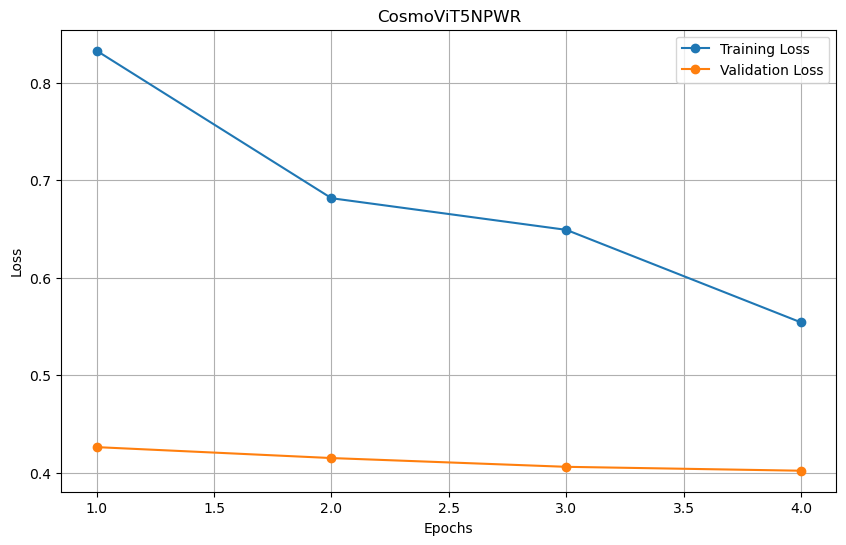

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(training_loss)), training_loss[1:], marker='o', label='Training Loss')
plt.plot(range(1, len(validation_loss)), validation_loss[1:], marker='o', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(ModelSpecification)
plt.grid(True)
plt.legend()
plt.savefig(f'{folder_path}/{ModelSpecification}Loss.png')
plt.show()

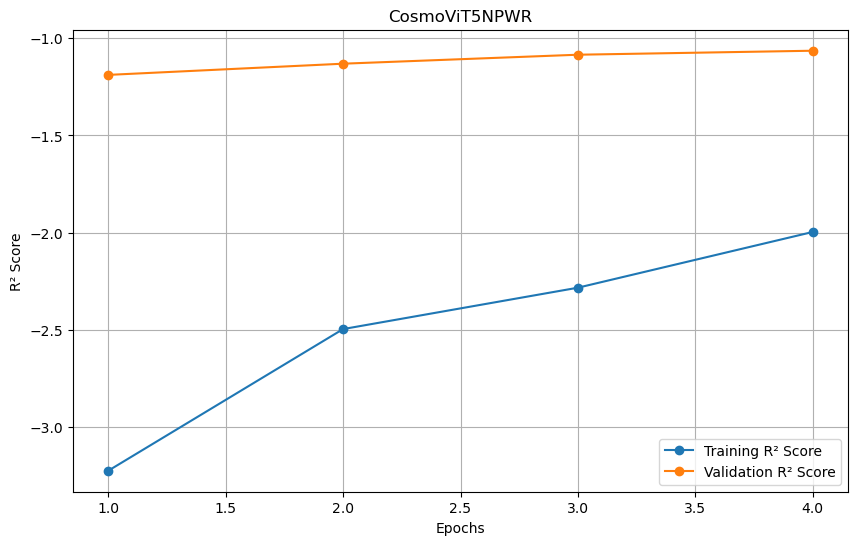

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(training_r2)), training_r2[1:], marker='o', label='Training R² Score')
plt.plot(range(1, len(validation_r2)), validation_r2[1:], marker='o', label='Validation R² Score')
plt.xlabel('Epochs')
plt.ylabel('R² Score')
plt.title(ModelSpecification)
plt.grid(True)
plt.legend()
plt.savefig(f'{folder_path}/{ModelSpecification}R2Score.png')
plt.show()

In [25]:
torch.save(model.state_dict(), f'{folder_path}/{ModelSpecification}.pth')
# notify(f"{ModelSpecification} Done!")

In [1]:
arr = np.load(f'{folder_path}/ValidationLoss{ModelSpecification}.npy')
print(len(arr))
print("Done")

NameError: name 'np' is not defined